In [33]:
import yaml

In [34]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [93]:
if menu['all_stats']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from io import StringIO
    import requests
    from sklearn.preprocessing import MinMaxScaler
    from shapely.geometry import shape
    from shapely.ops import unary_union
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from fiona.crs import from_epsg
    from nbconvert import MarkdownExporter
    import nbformat
    import base64
    import pickle
    import plotly.graph_objects as go
    import osmnx as ox
    from shapely.geometry import box
    from matplotlib.lines import Line2D
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
    import contextily as cx
    import matplotlib.patheffects as pe
    from sklearn.preprocessing import robust_scale
    from sklearn.cluster import AgglomerativeClustering
    from rasterio.plot import show
    import plotly.express as px
    from shapely.geometry import shape
    from scipy.stats import linregress
    from rasterio.warp import reproject, Resampling
    from shapely.ops import transform
    from functools import partial
    import pyproj
    import warnings
    import plotly.offline as pyo
    import requests
    from bs4 import BeautifulSoup
    import pandas as pd
    import re
    import os
    from matplotlib.ticker import FuncFormatter
    from adjustText import adjust_text
    from matplotlib.ticker import ScalarFormatter
    import matplotlib.ticker as ticker
    import squarify
    import shutil
    #from pysal import lib
    #from pysal.explore import esda
    

## Text begins

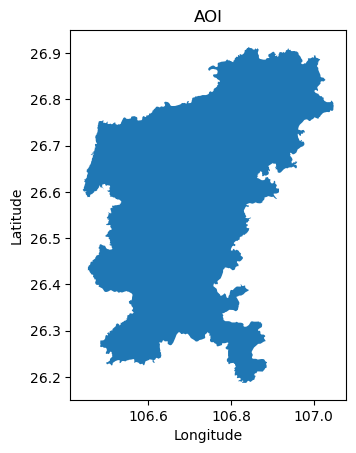

Merged pluvial data saved as mnt/city-directories/02-process-output/guiyang_merged_pluvial_data.tif
Merged fluvial data saved as mnt/city-directories/02-process-output/guiyang_merged_fluvial_data.tif
Error: No fluvial files found.
Merged combined data saved as mnt/city-directories/02-process-output/guiyang_merged_comb_data_utm.tif
city name: guiyang
country name:china


In [36]:
# SET UP ##############################################


# load global inputs, such as data sources that generally remain the same across scans

with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)
# run scan assembly and toolbox
%run 'scan_assembly.ipynb'
%run 'toolbox.ipynb'

# load city inputs files, to be updated for each city scan
with open("mnt/city-directories/01-user-input/city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)
city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
print(f"city name: {city}")
print(f"country name:{country}")
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry
# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
render_folder = Path('mnt/city-directories/03-render-output')
if not os.path.exists(output_folder):
    os.mkdir(output_folder)



## City Subdistricts available?

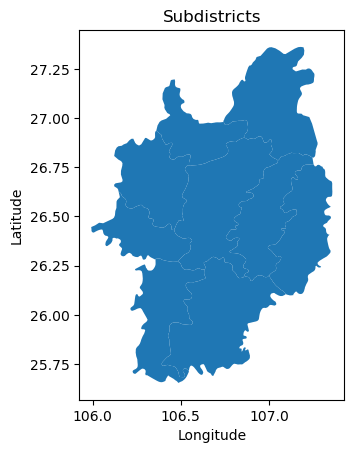

city subdistricts are larger than guiyang: Not available


In [37]:
#Intersect subdistricts to AOI - Is this necessary? We need ward level files
clip_extent = features.geometry.total_bounds
clip_box = box(*clip_extent)
lowest_admin_file = gpd.read_file(city_inputs['lowest_admin_shp']).to_crs(epsg = 4326) 
lowest_admin_country = lowest_admin_file.geometry
lower_admin_level = lowest_admin_country.cx[clip_box.bounds[0]:clip_box.bounds[2], clip_box.bounds[1]:clip_box.bounds[3]]
#plot check
fig, ax = plt.subplots()
lower_admin_level.plot(ax=ax)
plt.title('Subdistricts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

print(f"city subdistricts are larger than {city}: Not available")

In [38]:
#Standard Units
def enumerate_items(source):
    print("/n")
    for ele in enumerate(source): 
        print(ele)

def list_df_columns(df):
    field_list = list(df)
    enumerate_items(field_list)
    return field_list

def percentage_formatter(x, pos):
    return f'{x * 100 :,.0f}'

def millions_formatter(x, pos):
    return f'{x / 1000000 :,.0f}'


def hundred_thousand_formatter(x, pos):
    return f'{x / 100000 :,.0f}'

def billions_formatter(x, pos):
    return f'{x / 1000000000 :,.0f}'


## Lowest admin level available?

In [39]:
def get_lowest_admin_level():
    try:
        vector = features.reset_index()

        crs = 4326

        tags = {"boundary": "administrative"}

        minx, miny, maxx, maxy = vector.to_crs(epsg=4326).total_bounds

        all_admin_layers = ox.geometries.geometries_from_bbox(miny, maxy, minx, maxx, tags)

        lowest_admin_level = all_admin_layers["admin_level"].mode()[0]
        warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS")

        vector_gdf = all_admin_layers[all_admin_layers['admin_level'] == lowest_admin_level]

        lowest_admin_level_name = "Settlement"

        sub_city_gdf = gpd.clip(vector_gdf.to_crs(crs), vector.to_crs(crs))

        vector_gdf.loc[:, "pre_clip_area"] = vector_gdf['geometry'].area

        sub_city_gdf.loc[:, "post_clip_area"] = sub_city_gdf['geometry'].area

        sub_city_gdf.loc[:, "pct_clip_area"] = (sub_city_gdf["post_clip_area"] / sub_city_gdf["pre_clip_area"]) * 100

        sub_city_gdf = sub_city_gdf[sub_city_gdf['pct_clip_area'] > 50]

        sub_city_gdf['name:en'] = sub_city_gdf['name:en'].str.strip().replace('', np.nan).fillna(sub_city_gdf['name'])
  
        sub_city_gdf = sub_city_gdf.to_crs(crs)

        ax = sub_city_gdf.plot(alpha=0.8,
                               facecolor='none',
                               edgecolor='black',
                               label=f"{city}",
                               missing_kwds={"color": "white", "edgecolor": "black", "label": "none"},
                               zorder=5)
        

        plt.show()
        
        print("Yes, it is available")
    except Exception as e:
        print("Not available")
        print(e)
    warnings.filterwarnings("ignore")
    
get_lowest_admin_level() 

      

Not available
'pre_clip_area'


/Users/ipshitakarmakar/mambaforge/envs/geo/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning:

invalid value encountered in intersection

/Users/ipshitakarmakar/mambaforge/envs/geo/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Area of the city

In [40]:
area = calculate_aoi_area(features)
print(f"Area of the city of {city} is {area:2f} sq.km")

Area of the city of guiyang is 2531.550104 sq.km


## Koppen Climate

In [41]:
get_koeppen_classification()

Köppen climate classification:  Cwa (See https://en.wikipedia.org/wiki/Köppen_climate_classification for classes)


array([' Cwa'], dtype=object)

## Population in Oxford economics

In [42]:
city= city_inputs['city_name']
country= city_inputs['country_name']
in_oxford, oxford_full = check_city_in_oxford(city, country)

The population of Guiyang is 4279620.0


## Population from citypopulation.de

In [43]:
csv_path=os.path.join(render_folder, 'pop.csv')
pop_growth = get_de_pop_growth(city, country)

if pop_growth is not None:
    pop_growth.to_csv(csv_path, index=False)
else:
    print(f"{city} population data could not be retrieved from CityPopulation.de. Try manual entry instead.")
get_de_pop_growth(city, country)

,Location,Year,Population,Area_km,Source
0,Guìyáng [Guiyang],1990,1079652,0.0,citypopulation.de
1,Guìyáng [Guiyang],2000,1894344,0.0,citypopulation.de
2,Guìyáng [Guiyang],2010,2520061,0.0,citypopulation.de
3,Guìyáng [Guiyang],2020,4021275,0.0,citypopulation.de


### City Population Growth

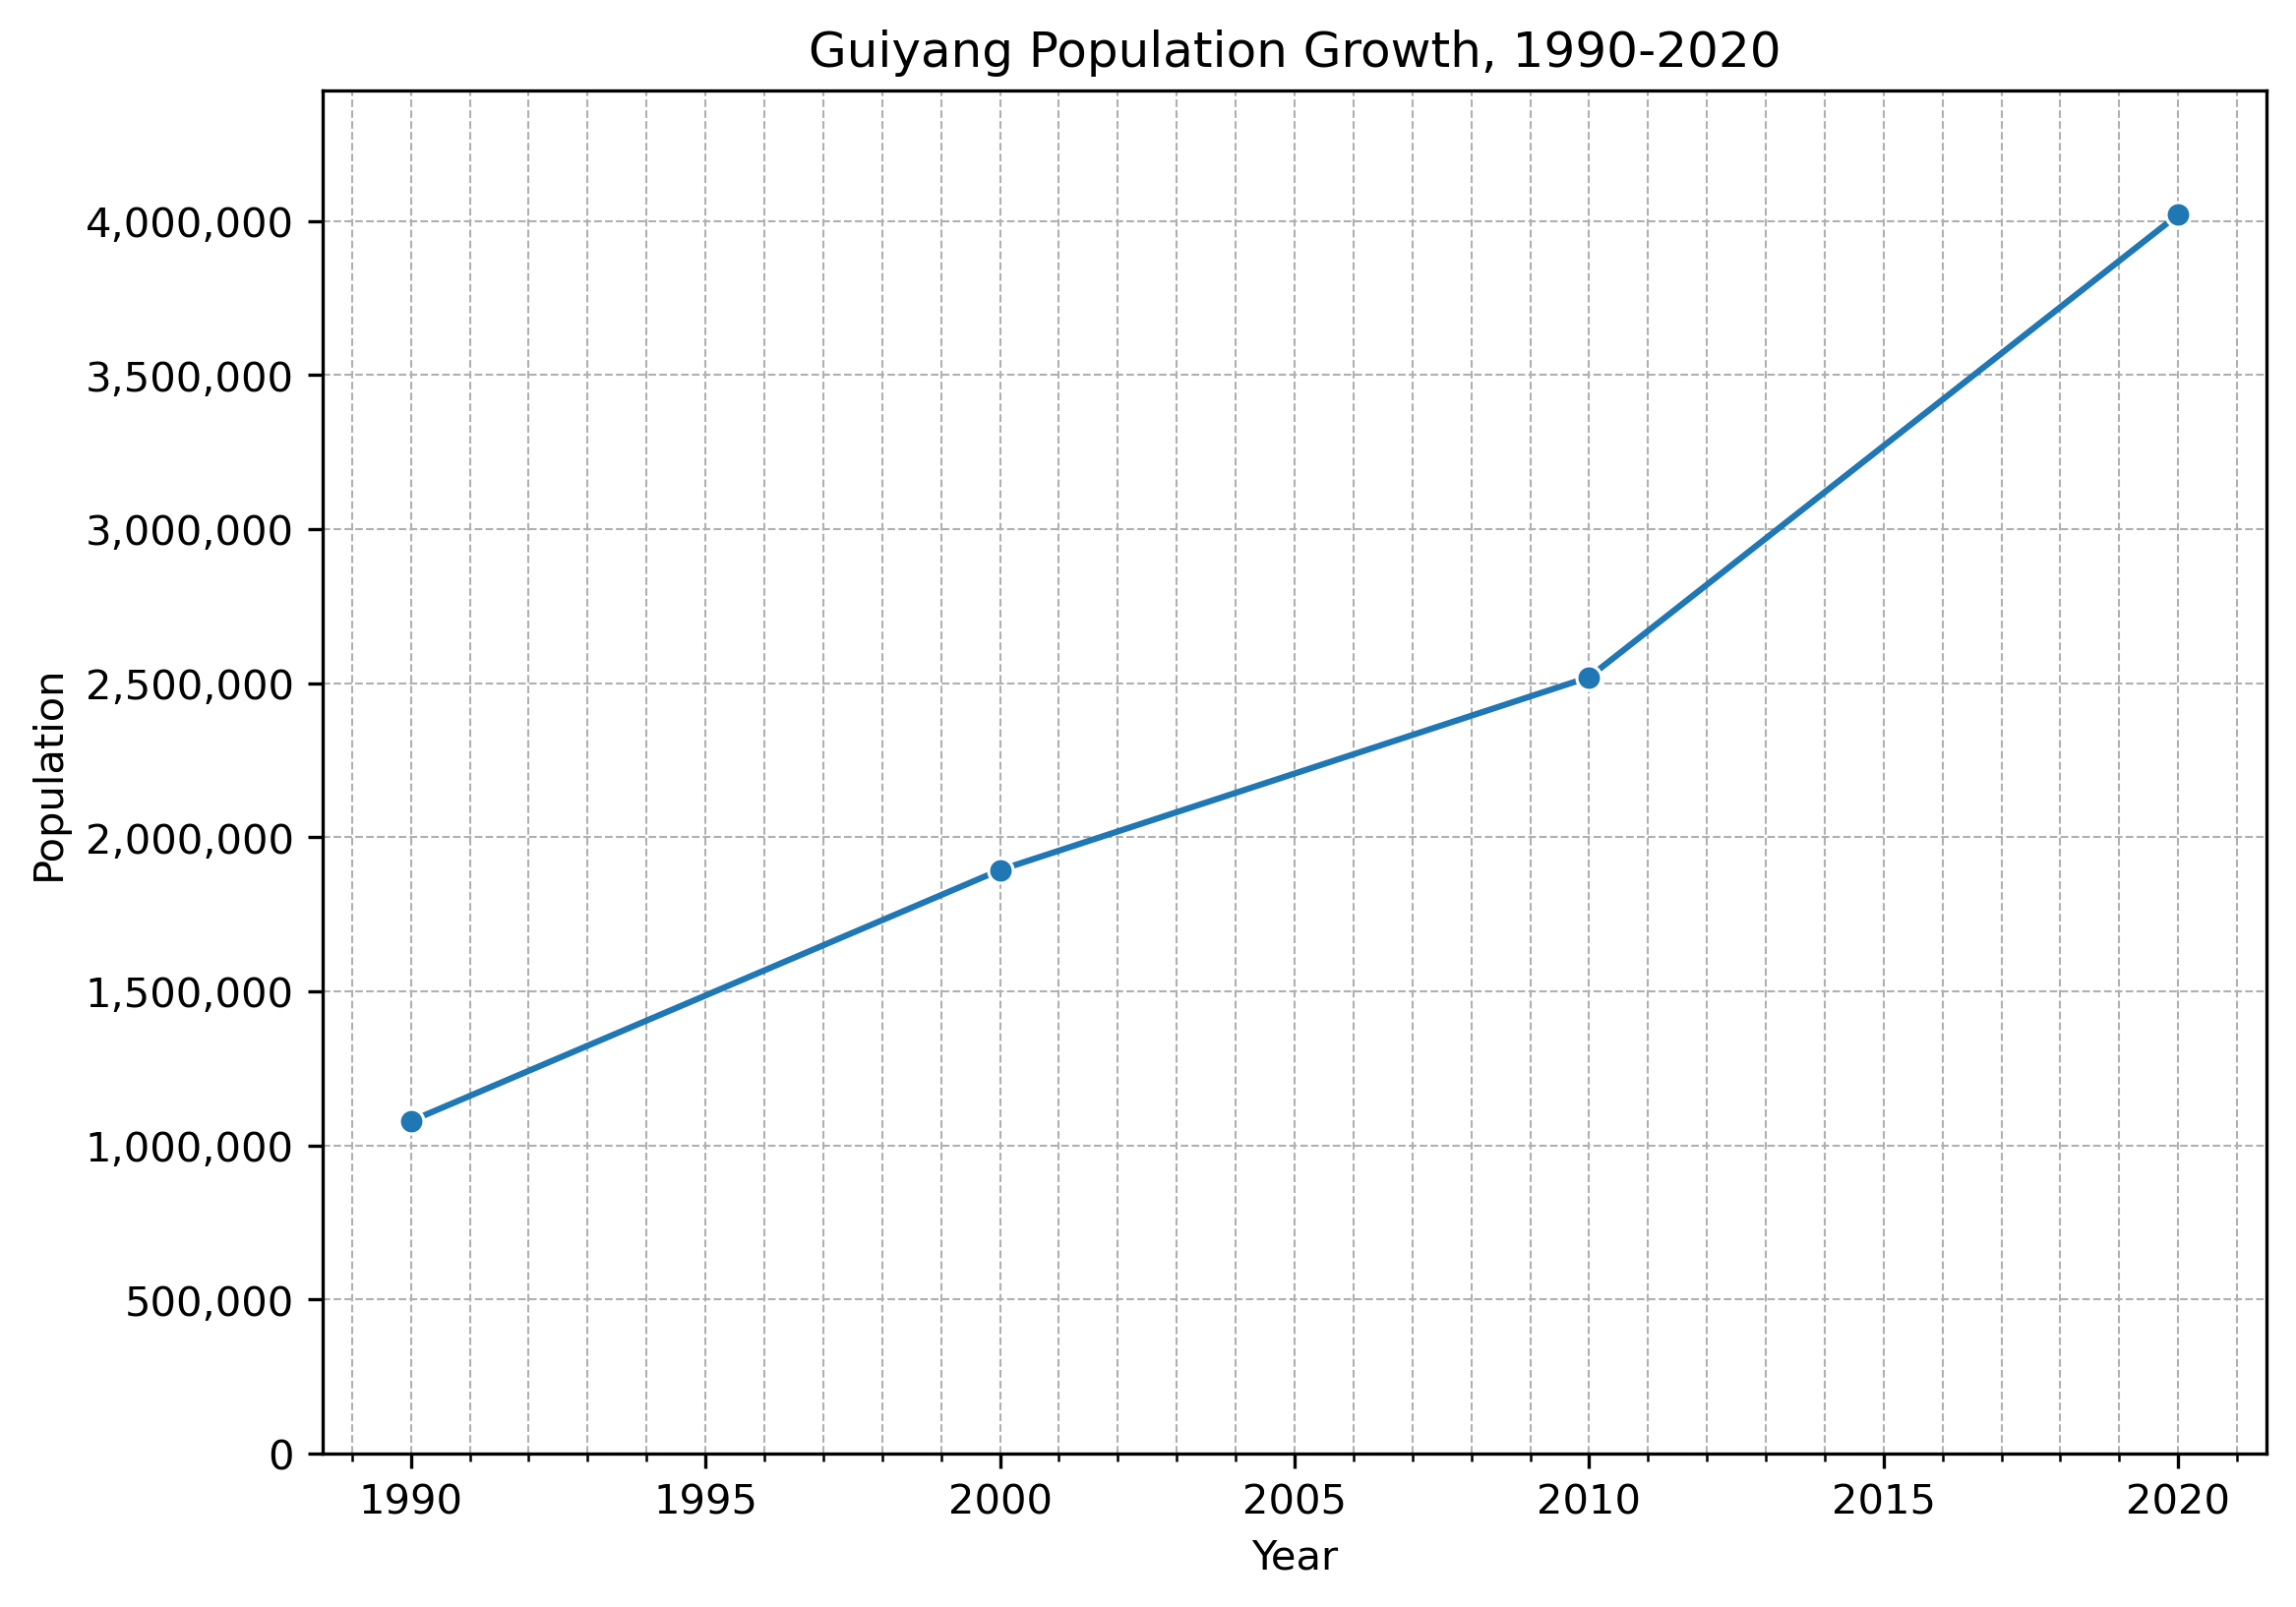

In [44]:
main()

In [45]:
def calculate_growth(pop_growth):
    pop_1 = pop_growth.iloc[0]['Population']
    pop_last = pop_growth.iloc[-1]['Population']
    year_1 = pop_growth.iloc[0]['Year']
    year_last = pop_growth.iloc[-1]['Year']
    pct_growth = round(((pop_last - pop_1) / pop_1), 3)
    if year_last - year_1 > 0:
        avg_growth = ((1 + pct_growth) ** (1 / (year_last - year_1))) - 1
    else:
        avg_growth = 0  

    growth_message = (
        f"{city}'s population increased by {pct_growth:.1%} from "
        f"{pop_1:,} in {year_1} to {pop_last:,} in {year_last}, "
        f"at an average annual growth rate of {avg_growth:.1%} according to CityPopulaton.de"
    )
    
    return growth_message

try:
    growth_message = calculate_growth(pop_growth)
    print(growth_message)
except Exception as e:
    print(f"An error occurred while calculating growth text: {str(e)}, try manual method instead")

Guiyang's population increased by 272.5% from 1,079,652 in 1990 to 4,021,275 in 2020, at an average annual growth rate of 4.5% according to CityPopulaton.de


## Benchmark cities 

In [46]:
city= city_inputs['city_name']
country= city_inputs['country_name']
bm_cities = find_benchmark_cities(city, country)
print(bm_cities)


Nearby cities: ['Kazakhstan', 'Almaty', 'Nur-Sultan', 'Myanmar', 'Mandalay', 'Nay Pyi Taw', 'Yangon', 'Kathmandu', 'Dushanbe', 'Can Tho', 'Da Nang', 'Hanoi', 'Haiphong', 'Ho Chi Minh City', 'Astrakhan', 'Barnaul', 'Chelyabinsk', 'Ekaterinburg', 'Irkutsk', 'Izhevsk', 'Kazan', 'Khabarovsk', 'Krasnodar', 'Krasnoyarsk', 'Lipetsk', 'Makhachkala', 'Moscow', 'Nizhniy Novgorod', 'Novokuznetsk', 'Novosibirsk', 'Omsk', 'Orenburg', 'Penza', 'Perm', 'Rostov-on-Don', 'Ryazan', 'Samara', 'Saratov', 'St Petersburg', 'Tomsk', 'Tula', 'Tyumen', 'Ufa', 'Ulyanovsk', 'Vladivostok', 'Volgograd', 'Voronezh', 'Yaroslavl']
['Mandalay', 'Kathmandu', 'St Petersburg']


In [47]:

countries = oxford_full['Country'].unique()

oxford_countries = oxford_full[oxford_full['Country'].isin(countries)]
oxford_countries = oxford_countries[(oxford_countries['Location'].str.contains("- Total")) | (oxford_countries['Country'].isin(countries))]

oxford_countries = oxford_countries.drop(columns=['Location'])

oxford_countries.head()

indicators = oxford_full[['Indicator']].drop_duplicates()

pop_dist_inds = indicators['Indicator'][(indicators['Indicator'].str.contains("Population")) & 
                                        (~indicators['Indicator'].isin(["Population 0-14", "Population 15-64", "Population 65+"]))].tolist()

emp_inds = indicators['Indicator'][indicators['Indicator'].str.contains("Employment")].tolist()

gva_inds = indicators['Indicator'][indicators['Indicator'].str.lower().str.contains("gross value added, real, us")].tolist()

extra_inds = ["Total population", "Employment - Total", "GDP, real, US$ - Total"]

## Bechmark cities Manual

In [48]:
bm_cities_manual = city_inputs['bm_cities_manual']
combined_bm_cities = list(np.unique(bm_cities + bm_cities_manual))
bm_cities = [c for c in combined_bm_cities if c != city]
print(bm_cities)

['Beijing', 'Guangzhou', 'Kathmandu', 'Mandalay', 'Shanghai', 'Shanxi', 'St Petersburg', 'Taiyuan']


In [49]:

oxford_pop_path = os.path.join(render_folder, 'oxford_pop.csv')
benchmark_pop_path = os.path.join(render_folder, 'pop_oxford_benchmark.csv')

oxford_full = pd.read_csv(global_inputs['oxford_global_source'])
oxford_locations = pd.read_csv(global_inputs['oxford_locations_source'])


filtered_oxford = oxford_full[oxford_full['Location'].isin([city] + bm_cities)]

if len(filtered_oxford) > 0:

    pop_oxford = filtered_oxford[
        filtered_oxford['Indicator'] == 'Total population'
    ].copy()

    pop_oxford['Group'] = np.where(pop_oxford['Location'] == city, city, 'Benchmark')
    pop_oxford['Group'] = pd.Categorical(pop_oxford['Group'], categories=[city, 'Benchmark'], ordered=True)


    pop_oxford = pop_oxford.melt(
        id_vars=['Group', 'Location', 'Country'],
        value_vars=[col for col in pop_oxford.columns if col.isdigit()],
        var_name='Year',
        value_name='Total population'
    ).pivot_table(
        values='Total population',
        index=['Group', 'Location', 'Country', 'Year'],
        aggfunc=np.sum
    ).reset_index()


    pop_oxford['Year'] = pop_oxford['Year'].astype(int)
    pop_oxford['Population'] = pop_oxford['Total population'] * 1000
    pop_oxford['Source'] = 'Oxford'
    pop_oxford['Method'] = 'Oxford'
    pop_oxford = pop_oxford[['Group', 'Location', 'Country', 'Year', 'Population', 'Source', 'Method']]
    pop_oxford = pop_oxford[pop_oxford['Year'] <= 2021].dropna(subset=['Population']).sort_values(by='Group')

    bm_areas = pd.read_csv(global_inputs['oxford_areas_source'])
    bm_areas['Location'] = bm_areas['Location'].str.title()

    if bm_areas.duplicated(subset=['Location']).any():
        raise ValueError("Multiple Oxford Economics cities have been matched with the same name")

    pop_oxford = pop_oxford.merge(bm_areas, on='Location', how='left')
else:
    pop_oxford = pd.DataFrame({
        'Group': pd.Categorical([], categories=[city, 'Benchmark'], ordered=True),
        'Location': pd.Series(dtype='str'),
        'Country': pd.Series(dtype='str'),
        'Year': pd.Series(dtype='int'),
        'Population': pd.Series(dtype='float'),
        'Source': pd.Series(dtype='str'),
        'Method': pd.Series(dtype='str')
    })

pop_oxford.to_csv(oxford_pop_path, index=False)

benchmark_2021 = pop_oxford[(pop_oxford['Group'] == 'Benchmark') & (pop_oxford['Year'] == 2021)]

benchmark_2021.to_csv(benchmark_pop_path, index=False)





## Population Density Manual

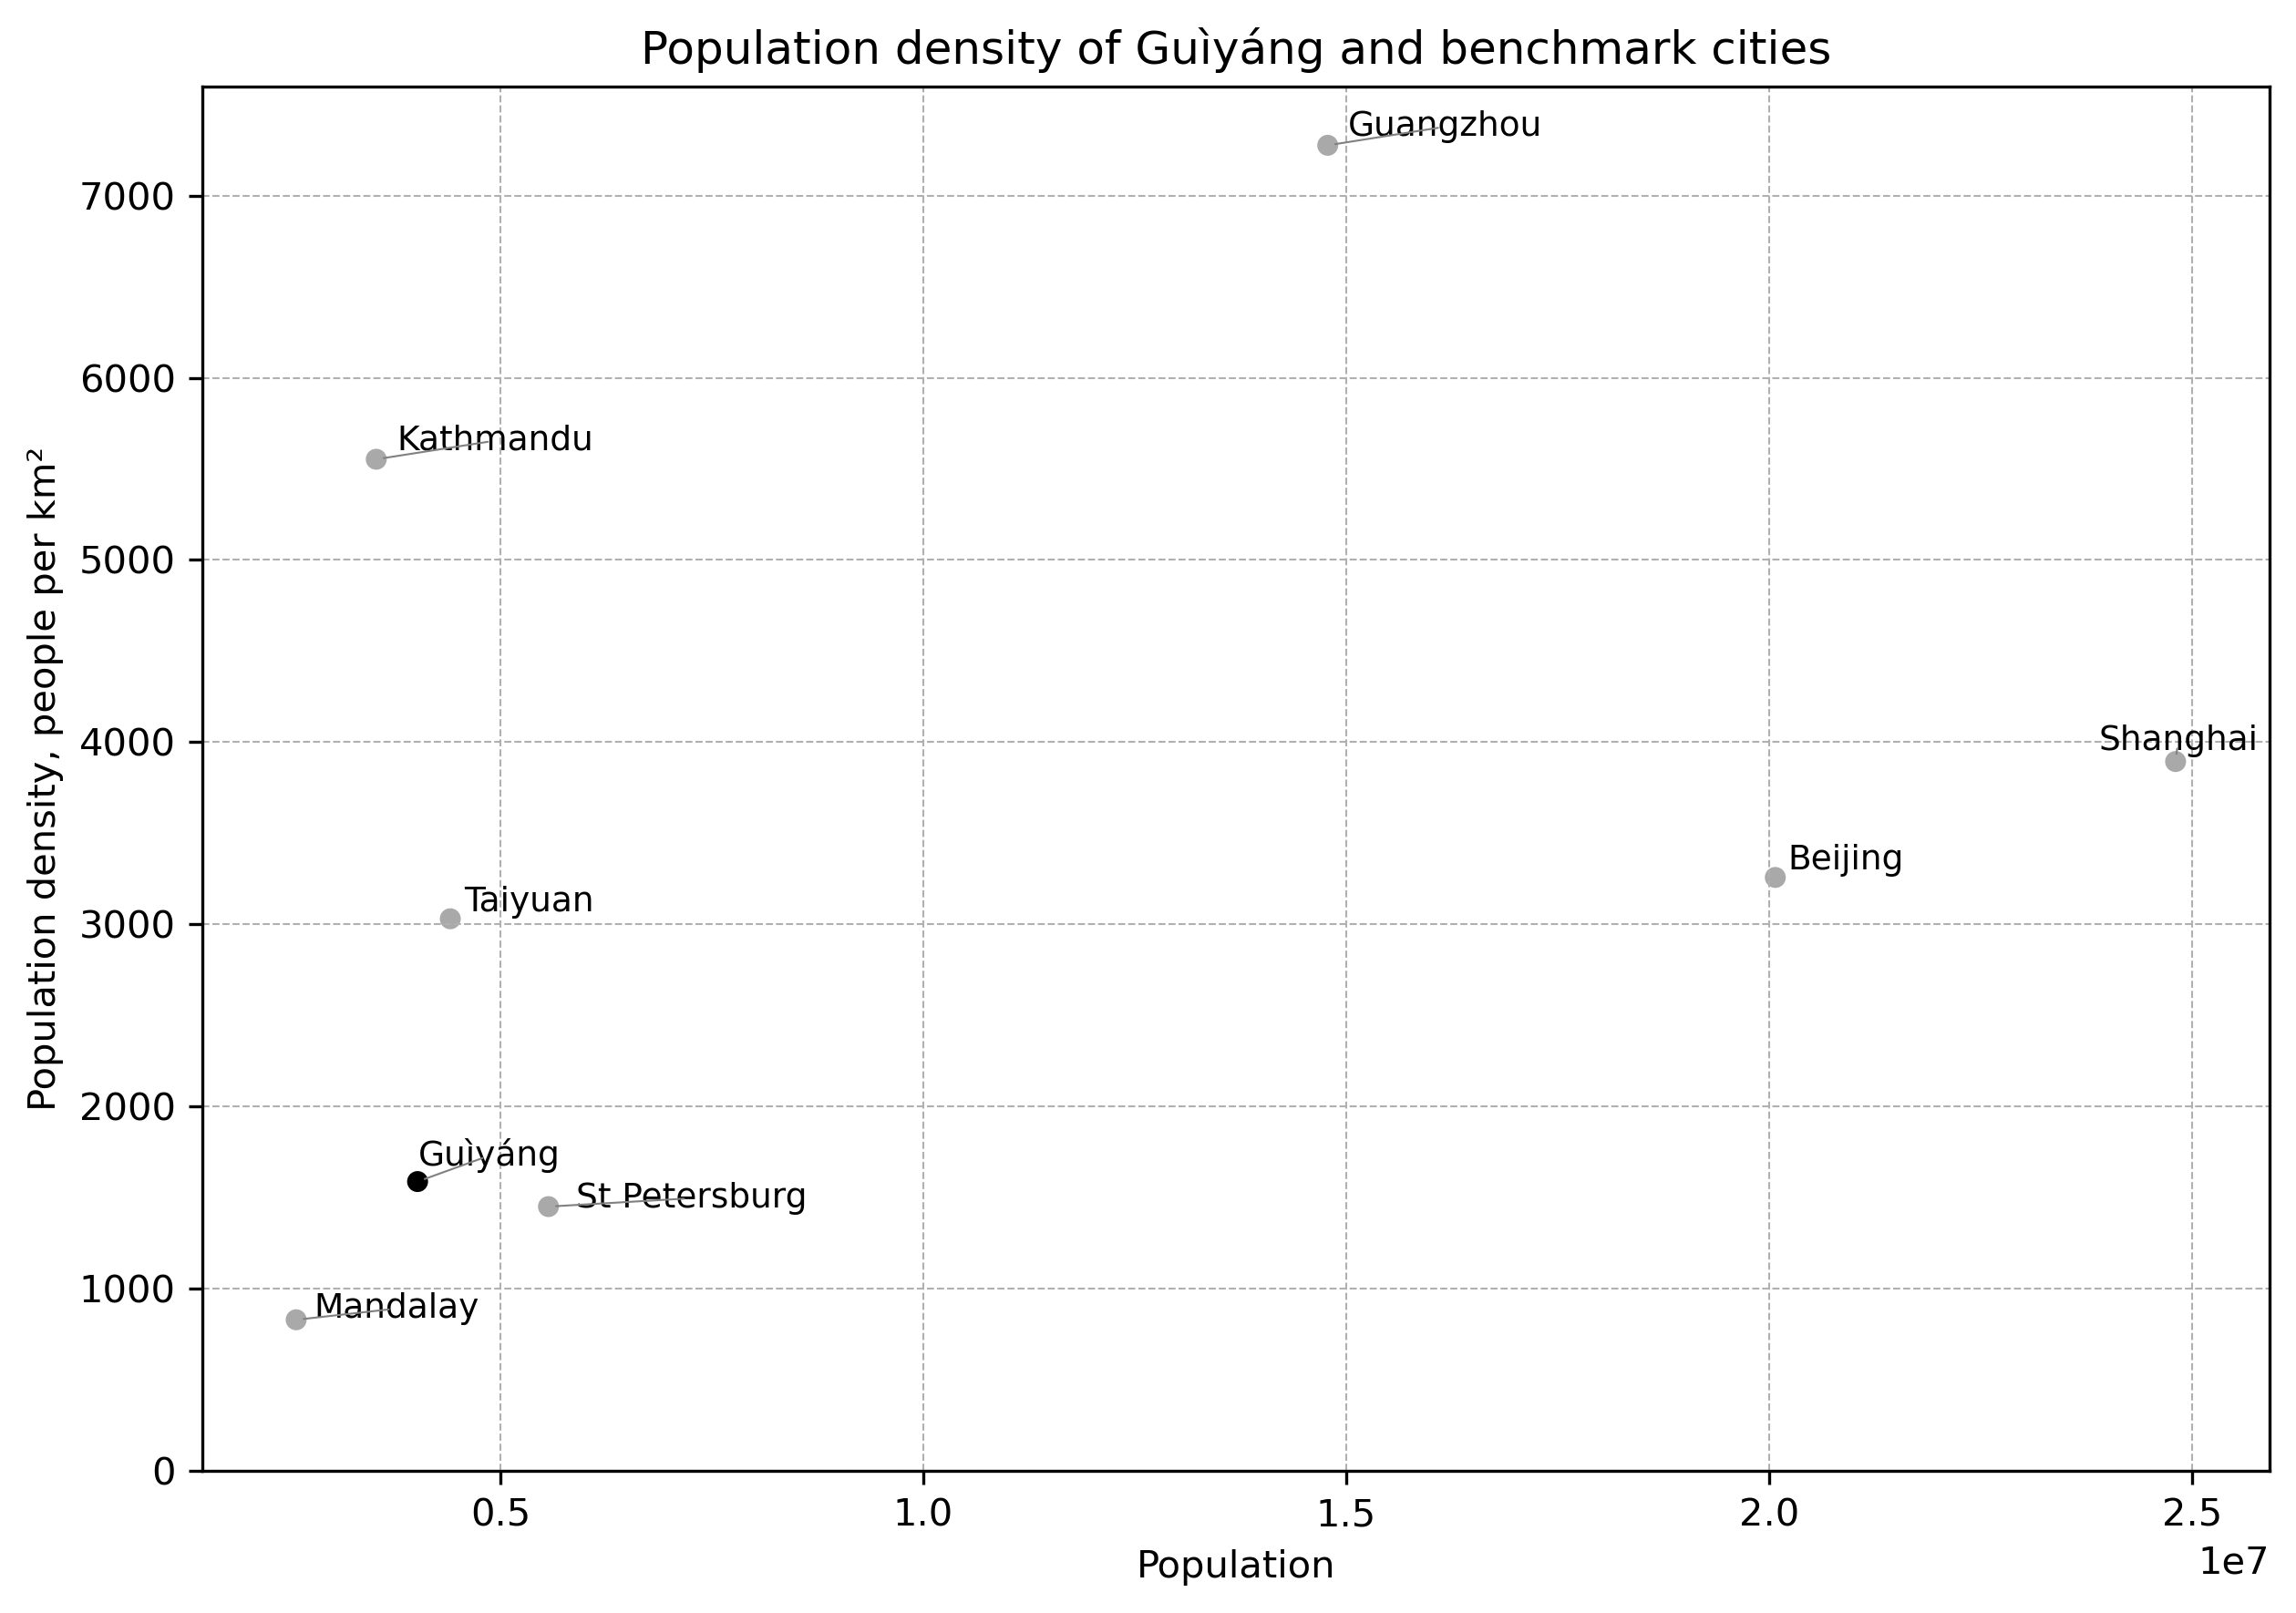

In [50]:
city = "Guìyáng"
def plot_population_density(pop_manual_path):
    pop_manual = pd.read_csv(pop_manual_path)

    density = pop_manual.loc[pop_manual.groupby('Location')['Year'].idxmax()]

    
    density['Population'] = pd.to_numeric(density['Population'], errors='coerce')
    density['Area_km'] = pd.to_numeric(density['Area_km'], errors='coerce')

    
    density['Density'] = density['Population'] / density['Area_km']
    density = density.dropna(subset=['Population', 'Density'])
    density = density.sort_values(by='Density', ascending=False)

    
    if city in density['Location'].values:
        city_pop_density = density.loc[density['Location'] == city, 'Density'].values[0]
    else:
        raise ValueError(f"City '{city}' not found in the dataset.")

    
    hues = {'Benchmark': 'darkgrey', city: '#000000'}

    
    plt.figure(figsize=(8.5, 6), dpi=300)
    sns.scatterplot(data=density, x='Population', y='Density', hue='Group', palette=hues, legend=False)

    texts = []
    for i, row in density.iterrows():
        texts.append(plt.text(row['Population'], row['Density'], row['Location'], fontsize=9))

    
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
                expand_text=(2, 1.05),  # Adjust this factor to move text closer
                only_move={'points': 'xy', 'texts': 'xy'},  # Move points and text
                lim=1000)

    plt.ylim(0, None)
    plt.title(f'Population density of {city} and benchmark cities')
    plt.xlabel('Population')
    plt.ylabel('Population density, people per km²')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    plt.savefig(Path(render_folder) / f"{city.lower().replace(' ', '_')}-pop-density.png", dpi=300,bbox_inches='tight')
    plt.show()

    # Plotly 
    fig = px.scatter(density, x='Population', y='Density', color='Group', 
                     color_discrete_map=hues,
                     labels={'Population': 'Population', 'Density': 'Population density, people per km²'},
                     log_x=False, log_y=False,
                     hover_name="Location")
    fig.update_layout(
    autosize=True,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
        yaxis=dict(
        range=[0, None]  
    )

    fig.write_html(Path(render_folder) / f"{city.lower().replace(' ', '_')}-pop-density-plotly.html",full_html=False, include_plotlyjs='cdn')
    fig.show()
plot_population_density("mnt/city-directories/01-user-input/pop_manual.csv")

In [51]:
city = city_inputs['city_name']
country = city_inputs['country_name']
try:
    oxford_full = pd.read_csv(global_inputs['oxford_global_source'])
    if city in oxford_full['Location'].values:
        create_national_shares_plot()
    else:
        print("City is not in oxford economics")
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['Group', 'Location', 'Indicator', 'Percentage'] but received: Percentage of National Shares


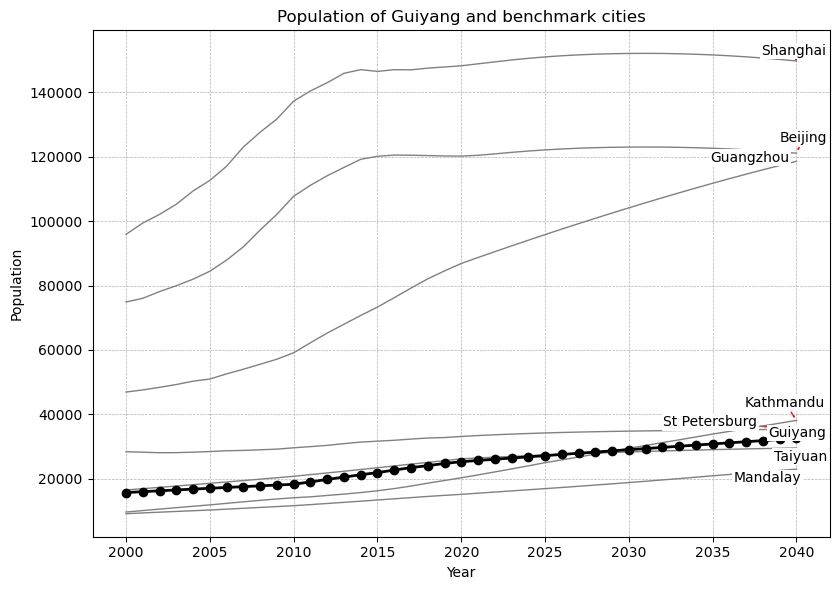

In [52]:
try:
    oxford_full = pd.read_csv(global_inputs['oxford_global_source'])
    if city in oxford_full['Location'].values:
        oxford_pop_growth_plot()
    else:
        print("City is not in oxford economics")
except Exception as e:
    print(f"An error occurred: {e}")


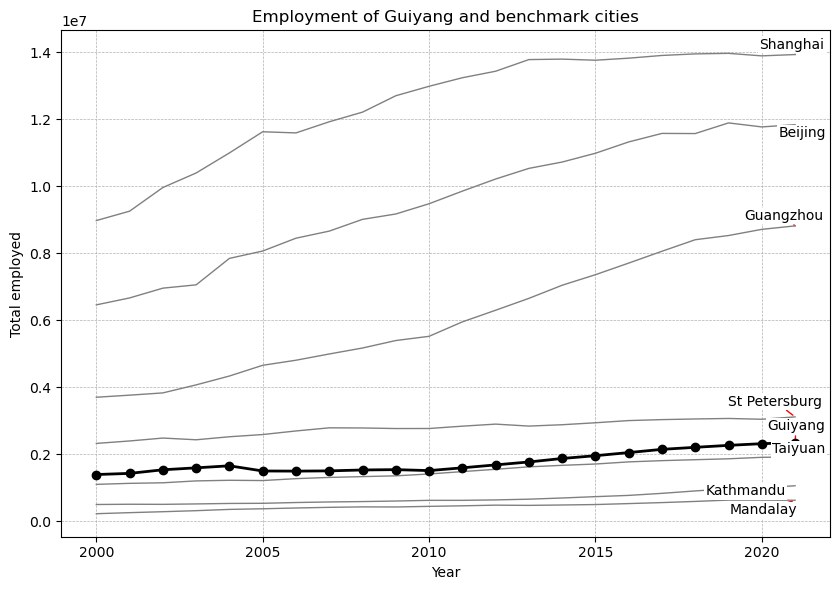

In [53]:
if city in oxford_full['Location'].values:
        oxford_emp_growth_plot()
else:
        print("City is not in oxford economics")

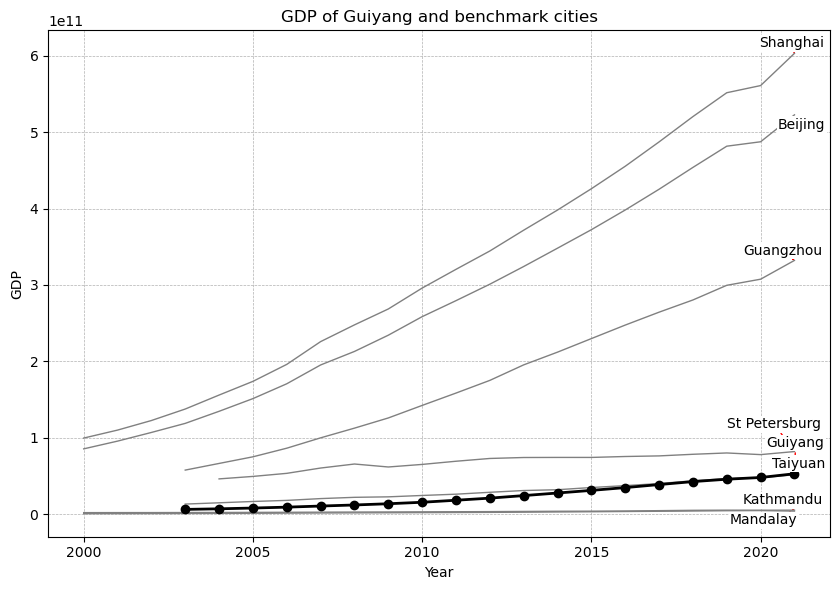

In [54]:
if city in oxford_full['Location'].values:
        oxford_gdp_growth_plot()
else:
        print("City is not in oxford economics")



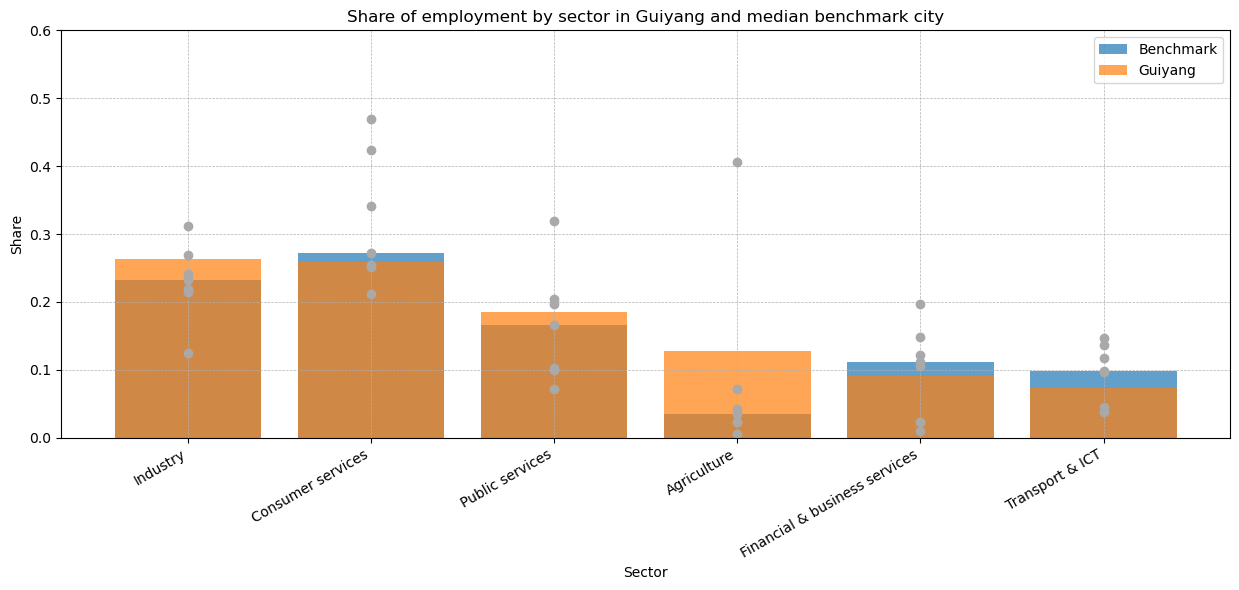

In [55]:
if city in oxford_full['Location'].values:
        oxford_emp_gva_shares_plot()
else:
        print("City is not in oxford economics")


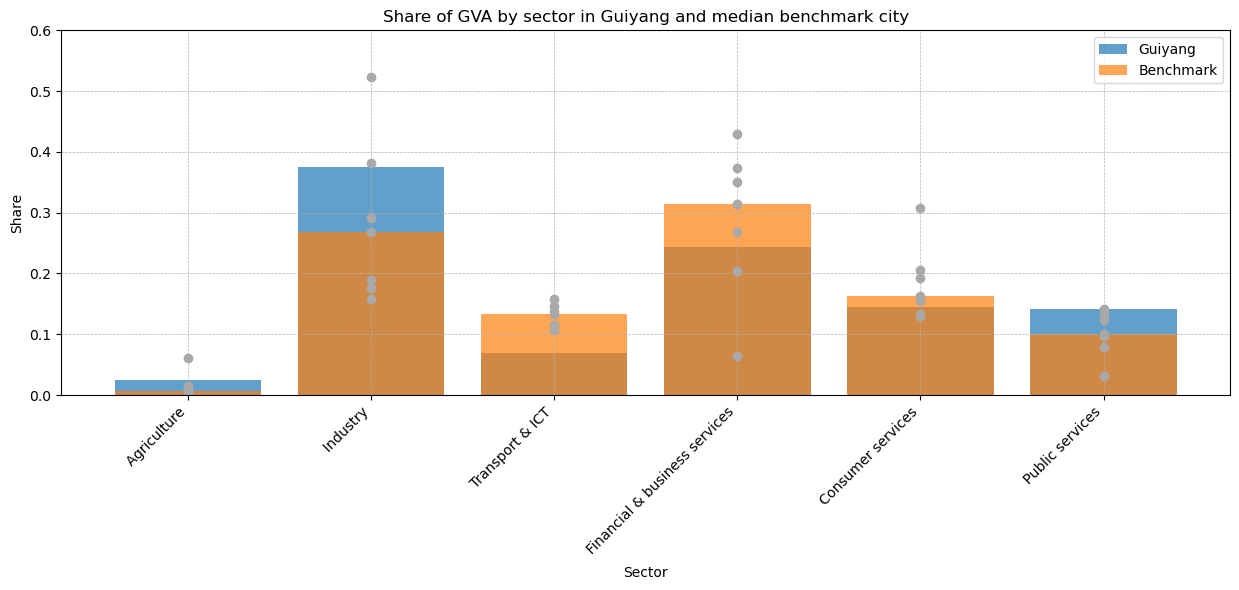

In [56]:
if city in oxford_full['Location'].values:
        oxford_gva_inequality_plot()
else:
        print("City is not in oxford economics")

## Population distribution by age and sex

In [57]:
city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
age_stats()

under5: 9.17%
youth (15-24): 24.90%
working_age (15-64): 0.72%
elderly (60+): 31.32%
reproductive_age, percent of women (15-50): 53.75%
sex_ratio: -97.94 males to 100 females


In [58]:
#Text option 1 - Delta and Range

def find_highest_lowest_pixel_value_path(raster_path):
    try:
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1)
            highest_value = round(raster_data.max(), 2)
            lowest_value = round(raster_data[raster_data > 0].min(), 2) 
            print(f"Values range from {lowest_value:.2f} units to {highest_value:.2f} units")

            return highest_value, lowest_value
        
    except Exception as e:
        print("Error:", e)
        return None, None

In [59]:
#Text option 1 - Delta and Range
def find_highest_lowest_pixel_value(raster_data):
    try:
        valid_values = raster_data[~np.isnan(raster_data)].flatten()
        highest_value = round(np.nanmax(valid_values), 2)
        lowest_value = round(np.nanmin(valid_values), 2)
        print(f"Values range from {lowest_value:.2f} units to {highest_value:.2f} units")

        return highest_value, lowest_value
    
    except Exception as e:
        print("Error:", e)
        return None, None



In [60]:
def find_highest_lowest_pixel_value_path(raster_path):
    try:
        with rasterio.open(raster_path) as src:
            raster_data = src.read(1) 
        valid_values = raster_data[~np.isnan(raster_data)].flatten()
        highest_value = round(np.nanmax(valid_values), 2)
        lowest_value = round(np.nanmin(valid_values), 2)
        print(f"Values range from {lowest_value:.2f} units to {highest_value:.2f} units")

        return highest_value, lowest_value
    
    except Exception as e:
        print("Error:", e)
        return None, None

In [61]:
# def create_raster_clusters(raster_data, n_clusters=5):
#     try:
#         # Open the raster file
#         with rasterio.open(raster_path) as src:
#             raster_data = src.read(1)
#             transform = src.transform
#             meta = src.meta
        
#         # Load the shapefile
#         features = aoi_file.geometry
        
#         # Ensure the shapefile is in the same CRS as the raster
#         if features.crs != meta['crs']:
#             features = features.to_crs(meta['crs'])
        
#         # Convert shapefile geometries to mask
#         geometries = [shape(geom) for geom in features.geometry]
#         mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=raster_data.shape)

#         # Apply the mask to the raster data
#         masked_raster_data = np.where(mask, raster_data, np.nan)

#         # Flatten and prepare data for clustering
#         flat_data = masked_raster_data.flatten()
#         valid_data = flat_data[~np.isnan(flat_data)]  # Remove NaNs

#         if valid_data.size == 0:
#             raise ValueError("No valid data available for clustering.")
        
#         # Prepare data for clustering
#         flat_data_reshaped = valid_data.reshape(-1, 1)

#         # Perform clustering
#         clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(flat_data_reshaped)
#         cluster_labels = np.full(raster_data.shape, fill_value=-1, dtype=int)
#         cluster_labels[~np.isnan(masked_raster_data)] = clustering.labels_

#         return cluster_labels

#     except Exception as e:
#         print("Error:", e)
#         return None

# def plot_cluster_labels_plotly(cluster_labels):
#     if cluster_labels is not None:
#         fig = px.imshow(cluster_labels, color_continuous_scale='viridis')
#         fig.update_layout(
#             xaxis_title='Column Index',
#             yaxis_title='Row Index',
#             legend_title='Cluster'
#         )
#         fig.show()
#     else:
#         print("No cluster labels to plot.")

# # Example usage
# raster_path = os.path.join(output_folder, f"{city}_population.tif")
# cluster_labels = create_raster_clusters(raster_path)
# if cluster_labels is not None:
#     plot_cluster_labels_plotly(cluster_labels)


In [62]:
# def create_raster_clusters(raster_path, n_clusters=5):
#     try:
#         # Open the raster file
#         with rasterio.open(raster_path) as src:
#             raster_data = src.read(1)
#             transform = src.transform
#             meta = src.meta
        
#         # Load the shapefile
#         features = aoi_file.geometry
        
#         # Ensure the shapefile is in the same CRS as the raster
#         if features.crs != meta['crs']:
#             features = features.to_crs(meta['crs'])
        
#         # Convert shapefile geometries to mask
#         geometries = [shape(geom) for geom in features.geometry]
#         mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=raster_data.shape)

#         # Apply the mask to the raster data
#         masked_raster_data = np.where(mask, raster_data, np.nan)

#         # Flatten and prepare data for clustering
#         flat_data = masked_raster_data.flatten()
#         valid_data = flat_data[~np.isnan(flat_data)]  # Remove NaNs

#         if valid_data.size == 0:
#             raise ValueError("No valid data available for clustering.")
        
#         # Prepare data for clustering
#         flat_data_reshaped = valid_data.reshape(-1, 1)

#         # Perform clustering
#         clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(flat_data_reshaped)
#         cluster_labels = np.full(raster_data.shape, fill_value=-1, dtype=int)
#         cluster_labels[~np.isnan(masked_raster_data)] = clustering.labels_

#         return cluster_labels

#     except Exception as e:
#         print("Error:", e)
#         return None

# def plot_cluster_labels_plotly(cluster_labels):
#     if cluster_labels is not None:
#         fig = px.imshow(cluster_labels, color_continuous_scale='viridis')
#         fig.update_layout(
#             xaxis_title='Column Index',
#             yaxis_title='Row Index',
#             legend_title='Cluster'
#         )
#         fig.show()
#     else:
#         print("No cluster labels to plot.")

# # Example usage
# raster_path = os.path.join(output_folder, f"{city}_population.tif")
# cluster_labels = create_raster_clusters(raster_path)
# if cluster_labels is not None:
#     plot_cluster_labels_plotly(cluster_labels)

In [63]:
# def get_raster_cluster_labels(raster_path,n_clusters=5):
#     try:
#         # Open the raster file
#         with rasterio.open(raster_path) as src:
#             raster_data = src.read(1)
#             transform = src.transform
#             meta = src.meta

#         # Load the shapefile
#         features = aoi_file.geometry
        
#         # Ensure the shapefile is in the same CRS as the raster
#         if features.crs != meta['crs']:
#             features = features.to_crs(meta['crs'])
        
#         # Convert shapefile geometries to mask
#         geometries = [shape(geom) for geom in features.geometry]
#         mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=raster_data.shape)

#         # Apply the mask to the raster data
#         masked_raster_data = np.where(mask, raster_data, np.nan)

#         # Flatten the masked raster data
#         flat_data = masked_raster_data.flatten()
#         valid_data = flat_data[~np.isnan(flat_data)]  # Remove NaNs

#         if valid_data.size == 0:
#             raise ValueError("No valid data available for clustering.")
        
#         # Prepare data for clustering
#         flat_data_reshaped = valid_data.reshape(-1, 1)

#         # Perform agglomerative clustering
#         clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(flat_data_reshaped)
#         cluster_labels = np.full(raster_data.shape, fill_value=-1, dtype=int)
#         cluster_labels[~np.isnan(masked_raster_data)] = clustering.labels_

#         return cluster_labels, transform

#     except Exception as e:
#         print("Error:", e)
#         return None, None

# # Example usage
# raster_path = os.path.join(output_folder, f"{city}_population.tif")
# cluster_labels, transform = get_raster_cluster_labels(raster_path)
# if cluster_labels is not None:
#     plot_cluster_labels_plotly(cluster_labels)

In [64]:
# from rasterio.crs import CRS

# # Define the Affine transformation matrix
# affine_transform = transform

# # Define the EPSG code for the CRS
# epsg_code = 4326 

# # Create a CRS object
# crs = CRS.from_epsg(epsg_code)

In [65]:
# def get_cluster_boundaries(cluster_labels, transform):
#     # Get unique cluster labels
#     unique_labels = np.unique(cluster_labels)

#     # Initialize a list to store cluster boundary polygons
#     cluster_polygons = []

#     # Iterate over each unique cluster label
#     for label in unique_labels:
#         # Create a mask for pixels with the current label
#         mask = cluster_labels == label

#         # Get the indices of non-zero elements in the mask
#         nonzero_indices = np.argwhere(mask)

#         # Calculate the bounding box of the cluster
#         min_row, min_col = np.min(nonzero_indices, axis=0)
#         max_row, max_col = np.max(nonzero_indices, axis=0)

#         # Calculate the bounding box coordinates
#         minx, miny = transform * (min_col, min_row)
#         maxx, maxy = transform * (max_col, max_row)

#         # Create the bounding box polygon
#         geom = box(minx, miny, maxx, maxy)

#         # Transform the polygon to the desired CRS
#         geom = gpd.GeoSeries(geom, crs=crs).to_crs(crs)

#         # Add the polygon to the list
#         cluster_polygons.append(geom[0])  # Take the first element

#     # Combine all polygons into a GeoDataFrame
#     cluster_gdf = gpd.GeoDataFrame({'cluster_label': unique_labels}, geometry=cluster_polygons, crs=crs)

#     return cluster_gdf

# cluster_gdf = get_cluster_boundaries(cluster_labels, transform)

In [66]:
# def describe_cluster_location(cluster_gdf, aoi_file):
#     # Get the centroid of the city
#     city_centroid = shape(aoi_file.geometry.centroid.iloc[0])
        
#     # Get the centroid of the cluster with the highest value
#     highest_cluster = cluster_gdf[cluster_gdf['cluster_label'] == cluster_gdf['cluster_label'].max()]['geometry'].centroid.values[0]
#     # Get the centroid of the cluster with the lowest value
#     lowest_cluster = cluster_gdf[cluster_gdf['cluster_label'] == cluster_gdf['cluster_label'].min()]['geometry'].centroid.values[0]
    
#     # Determine the location of the clusters
#     highest_location = "north" if highest_cluster.y > city_centroid.y else "south"
#     lowest_location = "north" if lowest_cluster.y > city_centroid.y else "south"
    
#     if highest_cluster.x > city_centroid.x:
#         highest_location += " east"
#     elif highest_cluster.x < city_centroid.x:
#         highest_location += " west"
        
#     if lowest_cluster.x > city_centroid.x:
#         lowest_location += " east"
#     elif lowest_cluster.x < city_centroid.x:
#         lowest_location += " west"
        
#     # Check if the centroids are within a range of the city centroid 
#     center_range = 0.2  
#     center_clusters = cluster_gdf[cluster_gdf['geometry'].apply(lambda geom: abs(geom.centroid.x - city_centroid.x) < center_range and abs(geom.centroid.y - city_centroid.y) < center_range)]
    
#     if len(center_clusters) > 0:
#         if cluster_gdf['cluster_label'].max() == center_clusters['cluster_label'].max():
#             highest_location = "center"
#         else:
#             center_location = "center"
    
#     # Print statements describing cluster locations
#     print(f"The cluster with the highest value is located in the {highest_location} of the city.")
#     print(f"The cluster with the lowest value is located in the {lowest_location} of the city.")





In [67]:
# #Text option 4 - OLS
# #Bit tricky but might be fun
# if menu['summer_lst']:  
#     summer_path = os.path.join(output_folder, city + '_summer.tif')
#     with rasterio.open(summer_path) as src:
#         summer_data = src.read(1)
#         summer_data = np.nan_to_num(summer_data, nan=0) 
#         transform = src.transform
# def pixelwise_regression(pop_path, summer_path):
#     try:
#         # Open population raster
#         with rasterio.open(pop_path) as pop_src:
#             pop_data = pop_src.read(1)
#             pop_profile = pop_src.profile

#         # Open summer LST raster and reproject to match population raster
#         with rasterio.open(summer_path) as summer_src:
#             summer_data = summer_src.read(1)
#             summer_profile = summer_src.profile

#             # Reproject summer LST raster to match population raster
#             pop_data_resampled = np.zeros_like(summer_data)
#             reproject(
#                 source=pop_data,
#                 destination=pop_data_resampled,
#                 src_transform=pop_src.transform,
#                 src_crs=pop_src.crs,
#                 dst_transform=summer_src.transform,
#                 dst_crs=summer_src.crs,
#                 resampling=Resampling.bilinear
#             )

#         # Flatten the arrays
#         summer_flat = summer_data.flatten()
#         pop_flat = pop_data_resampled.flatten()

#         # Perform pixel-wise linear regression
#         slope, intercept, r_value, p_value, std_err = linregress(pop_flat, summer_flat)

#         # Check if p-value is significant
#         if np.isnan(p_value):
#             print("Regression is not significant. Results may not be reliable.")

#         return slope, intercept, r_value, p_value, std_err

#     except Exception as e:
#         print("Error:", e)
#         return None, None, None, None, None
        



## Population Density

In [68]:
# #Iterate
if menu['population']:  
     pop_path = os.path.join(output_folder, f"{city}_population.tif")
     with rasterio.open(pop_path) as src:
         pop_data = src.read(1)
         pop_data[pop_data == -9999] = np.nan
         pop_data = np.nan_to_num(pop_data, nan=0)
         transform = src.transform  

#     create_raster_clusters(pop_data, n_clusters=5)
#     plot_cluster_labels_plotly(cluster_labels)
#     if cluster_labels is not None:
#         print("Cluster labels shape:", cluster_labels.shape)
#         pop_cluster_gdf = get_cluster_boundaries(cluster_labels, transform)
#         pop_cluster = describe_cluster_location(pop_cluster_gdf, aoi_file)
#         pop_cluster
#    find_highest_lowest_pixel_value_path(pop_path)
#     pixelwise_regression(pop_path, summer_path)

## Economic Activity

In [69]:
if menu['raster_processing']:  
     raster_path = os.path.join(output_folder, f"{city}_avg_rad_sum.tif")
     with rasterio.open(raster_path) as src:
         rad_data = src.read(1)
         rad_data[rad_data == -9999] = np.nan
         rad_data = np.nan_to_num(rad_data, nan=0) 
        
         transform = src.transform
#     rad_cluster_labels = create_raster_clusters(rad_data, n_clusters=5)
#     plot_cluster_labels_plotly(rad_cluster_labels)
#     if cluster_labels is not None:
#         print("Cluster labels shape:", rad_cluster_labels.shape)
#         rad_cluster_gdf = get_cluster_boundaries(rad_cluster_labels, transform)
#         rad_cluster = describe_cluster_location(rad_cluster_gdf, aoi_file)
#         rad_cluster
     find_highest_lowest_pixel_value(rad_data)

Values range from 0.00 units to 8766.09 units


## Change in Economic Activity 

In [70]:
# if menu['raster_processing']:  
#     raster_path = os.path.join(output_folder, city + '_linfit.tif')
#     with rasterio.open(raster_path) as src:
#         linfit_data = src.read(1)
#         linfit_data[linfit_data == -9999] = np.nan
#         linfit_data = np.nan_to_num(linfit_data, nan=0) 
#         transform = src.transform
#     linfit_cluster_labels = create_raster_clusters(linfit_data, n_clusters=5)
#     plot_cluster_labels_plotly(linfit_cluster_labels)
#     if cluster_labels is not None:
#         print("Cluster labels shape:", linfit_cluster_labels.shape)
#         linfit_cluster_gdf = get_cluster_boundaries(linfit_cluster_labels, transform)
#         linfit_cluster = describe_cluster_location(linfit_cluster_gdf, aoi_file)
#         linfit_cluster
#     find_highest_lowest_pixel_value(linfit_data)

## Urban Extent and Change

In [71]:
wsf_stats()

The city's built-up area grew from 110.96 sq. km in 1985 to 397.06 in 2015 for 257.84% growth


## Land Cover

In [72]:
lc_stats()

## Photovoltaic Power Potential

In [73]:
extract_monthly_stats()

Seasonality is low to moderate, making solar energy available in only some of the months


## Land Surface Temperature

In [74]:

if menu['summer_lst']:  
    raster_path = os.path.join(output_folder, city + '_summer.tif')
    with rasterio.open(raster_path) as src:
        summer_data = src.read(1)
        summer_data[summer_data == -9999] = np.nan
        summer_data = np.nan_to_num(summer_data, nan=0) 
        nonzero_values = summer_data[(summer_data != 0) & (~np.isnan(summer_data))]

    if len(nonzero_values) > 0:
        lowest_value = np.min(nonzero_values)
        min_value = np.min(nonzero_values)
        max_value = np.max(nonzero_values)
        print(f"Values range from {min_value:.2f} to {max_value:.2f}")
    else:
        print("There are no non-zero values in the summer data.")


Values range from 19.92 to 57.31


## Green Spaces

In [75]:
if menu['green']:  
    NDVI_path = os.path.join(output_folder, city + '_NDVI_Annual.tif')
    with rasterio.open(NDVI_path) as src:
        NDVI_data = src.read(1)
        NDVI_data = np.nan_to_num(NDVI_data, nan=0) 
    find_highest_lowest_pixel_value(NDVI_data)

Values range from -0.19 units to 0.54 units


## Elevation

In [76]:
elev_stats()

Highest percentage entry for Elevation is 50.22% in the bin range 1200-1360


## Slope

In [77]:
if menu['slope']:  
    slope_path = os.path.join(output_folder, city + '_slope.tif')
    with rasterio.open(slope_path) as src:
        slope_data = src.read(1)
        slope_data[slope_data == -9999] = np.nan
        slope_data = np.nan_to_num(slope_data, nan=0) 
        transform = src.transform
    #slope_cluster_labels = create_raster_clusters(slope_data, n_clusters=5)
    #plot_cluster_labels_plotly(slope_cluster_labels)
    #if cluster_labels is not None:
        #print("Cluster labels shape:", slope_cluster_labels.shape)
        #slope_cluster_gdf = get_cluster_boundaries(slope_cluster_labels, transform)
        #slope_cluster = describe_cluster_location(slope_cluster_gdf, aoi_file)
        #slope_cluster
    find_highest_lowest_pixel_value(slope_data)

Values range from 0.00 units to 63.84 units


In [78]:
slope_stats()

Highest percentage entry for Slope is 33% in the bin range 10-20


## NDMI

In [79]:
if menu['ndmi']:  
    NDMI_path = os.path.join(output_folder, city + '_NDMI_Annual.tif')
    with rasterio.open(NDMI_path) as src:
        NDMI_data = src.read(1)
        NDMI_data = np.nan_to_num(NDMI_data, nan=0) 
    find_highest_lowest_pixel_value(NDMI_data)

Values range from -0.39 units to 0.47 units


## Flooding 

In [80]:
flood_timeline()

Tally of flood events
DEAD             6773
DISPLACED    21322670
BEGAN              21
dtype: int64


### Pluvial and OSM

In [81]:
get_pu_am()
#get_pu_roads()

5 of 26 (19.23%) health are located in a riverine flood risk zone with a minimum depth of 15 cm.
4 of 6 (66.67%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
0 of 2 (0.00%) fire are located in a riverine flood risk zone with a minimum depth of 15 cm.
23 of 138 (16.67%) schools are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/pu_osmpt.xlsx


### Pluvial Flooding and WSF

In [95]:
stats_by_year = get_pu_wsf()
if stats_by_year is not None:
    years = list(stats_by_year.keys())
    areas = list(stats_by_year.values())

    cumulative_areas = np.cumsum(areas)

    cumulative_stats_by_year = dict(zip(years, cumulative_areas))

    years_to_plot = sorted(years)  
    areas_to_plot = [cumulative_stats_by_year.get(year, np.nan) for year in years_to_plot]

    plt.figure(figsize=(8, 8))
    plt.plot(years_to_plot, areas_to_plot, marker='o', linestyle='-')
    plt.title('Areas exposed to surface water flooding')
    plt.xlabel('Year')
    plt.ylabel('Exposed area in sq.km')
    plt.grid(True)
    plt.tight_layout()
    render_path = os.path.join(render_folder, f"{city}_pu_wsf.png")
    plt.savefig(render_path)
    plt.close()
    print(f"PNG saved to {render_path}")

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years_to_plot, y=areas_to_plot, mode='lines+markers', name='Cumulative Flooded Area'))
    fig.update_layout(xaxis_title='Year',
                      yaxis_title='Exposed area (sq.km)',
                      yaxis=dict(range=[0, max(areas_to_plot) * 1.1]))
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')

wsf_stats_file = Path(output_folder / f"{city}_wsf_stats.csv")  
wsf = pd.read_csv(wsf_stats_file)
total_built_up_area = wsf['cumulative sq km'].iloc[-1]

if 2015 in stats_by_year:
    flooded_area_2015 = np.cumsum([stats_by_year[year] for year in years if year <= 2015])[-1]
    if total_built_up_area != 0:
        percentage_2015 = (flooded_area_2015 / total_built_up_area)*100
        print(f"As of 2015, {flooded_area_2015:.2f} sq.km of the city’s built-up area ({percentage_2015:.2f}%) was exposed to surface water flooding.")
    else:
        print("The city is not exposed to surface water flooding.")
else:
    print("No flooding data available for 2015.")



PNG saved to mnt/city-directories/03-render-output/guiyang_pu_wsf.png


As of 2015, 103.41 sq.km of the city’s built-up area (26.04%) was exposed to surface water flooding.


### Pluvial and Population

In [83]:
get_pu_pop_norm()

60th Percentile of Population Data (excluding zeros): 39.820377349853516
6.66% of densely populated areas are located within the rainwater flood risk zone with a minimum depth of 15 cm
Result saved to mnt/city-directories/02-process-output/pu_pop_area.csv


### Fluvial and OSM

In [84]:
get_fu_am()
#get_fu_roads()

2 of 26 (7.69%) health are located in a riverine flood risk zone with a minimum depth of 15 cm.
0 of 6 (0.00%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
0 of 2 (0.00%) fire are located in a riverine flood risk zone with a minimum depth of 15 cm.
3 of 138 (2.17%) schools are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/fu_osmpt.xlsx


### Fluvial and WSF

In [96]:
stats_by_year = get_fu_wsf()
if stats_by_year is not None:
    years = list(stats_by_year.keys())
    areas = list(stats_by_year.values())

    cumulative_areas = np.cumsum(areas)

    cumulative_stats_by_year = dict(zip(years, cumulative_areas))

    years_to_plot = sorted(years)
    areas_to_plot = [cumulative_stats_by_year.get(year, np.nan) for year in years_to_plot]

    plt.figure(figsize=(8, 8))
    plt.plot(years_to_plot, areas_to_plot, marker='o', linestyle='-')
    plt.title('Area exposed to River Flooding')
    plt.xlabel('Year')
    plt.ylabel('Exposed area in sq.km')
    plt.grid(True)
    plt.tight_layout()
    render_path = os.path.join(render_folder, f"{city}_fu_wsf.png")
    plt.savefig(render_path)
    plt.close()
    print(f"PNG saved to {render_path}")

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years_to_plot, y=areas_to_plot, mode='lines+markers', name='Area exposed to River Flooding'))
    fig.update_layout(xaxis_title='Year',
                      yaxis_title='Exposed area in sq.km',
                      yaxis=dict(range=[0, max(areas_to_plot) * 1.1]))
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')

    wsf_stats_file = Path(output_folder / f"{city}_wsf_stats.csv")  
    wsf = pd.read_csv(wsf_stats_file)
    total_built_up_area_2015 = wsf['cumulative sq km'].iloc[-1]
    total_built_up_area_1985 = wsf['cumulative sq km'].iloc[0]
    flooded_area_2015 = np.cumsum([stats_by_year[year] for year in years if year <= 2015])[-1]
    if total_built_up_area != 0:
        percentage_2015 = (flooded_area_2015 / total_built_up_area_2015) * 100
        print(f"In 2015, {flooded_area_2015:.2f} sq.m of the city’s cumulative built-up area ({percentage_2015:.2f}%) was exposed to fluvial flooding.")
    else:
        print("The city is not exposed to fluvial flooding.")

    flooded_area_1985 = np.cumsum([stats_by_year[year] for year in years if year <= 1985])[-1] if 1985 in stats_by_year else 0
    if total_built_up_area != 0:
        percentage_1985 = (flooded_area_1985 / total_built_up_area_1985) * 100
        print(f"In 1985, {flooded_area_1985:.2f} sq.m of the city’s cumulative built-up area ({percentage_1985:.2f}%) was exposed to fluvial flooding.")
    else:
        print("The city was not exposed to fluvial flooding.")
else:
    print("No areas calculated.")
    




810.354708629123
PNG saved to mnt/city-directories/03-render-output/guiyang_fu_wsf.png


In 2015, 7.62 sq.m of the city’s cumulative built-up area (1.92%) was exposed to fluvial flooding.
In 1985, 3.06 sq.m of the city’s cumulative built-up area (2.76%) was exposed to fluvial flooding.


### Fluvial and Population

In [86]:
get_fu_pop_norm()

60th Percentile of Population Data (excluding zeros): 39.820377349853516
0.16% of densely populated areas are located within the fluvial flood risk zone with a minimum depth of 15 cm
Result saved to mnt/city-directories/02-process-output/fu_pop_area.csv


## Combined Flooding

### Combined Flooding and WSF

In [87]:
#comb and wsf
stats_by_year = get_comb_wsf()
if stats_by_year is not None:
    years = list(stats_by_year.keys())
    areas = list(stats_by_year.values())

    cumulative_areas = np.cumsum(areas)

    cumulative_stats_by_year = dict(zip(years, cumulative_areas))

    years_to_plot = sorted(years)  
    areas_to_plot = [cumulative_stats_by_year.get(year, np.nan) for year in years_to_plot]

    plt.figure(figsize=(8, 8))
    plt.plot(years_to_plot, areas_to_plot, marker='o', linestyle='-')
    plt.title('Area exposed to Combined Flooding')
    plt.xlabel('Year')
    plt.ylabel('Exposed area in sq.km')
    plt.grid(True)
    plt.tight_layout()
    render_path = os.path.join(render_folder, f"{city}_comb_wsf.png")
    plt.savefig(render_path)
    plt.close()
    print(f"PNG saved to {render_path}")

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=years_to_plot, y=areas_to_plot, mode='lines+markers', name='Area exposed to River Flooding'))
    fig.update_layout(xaxis_title='Year',
                      yaxis_title='Exposed area in sq.km',yaxis=dict(range=[0, max(areas_to_plot) * 1.1]))
    fig.show()
    fig.write_html(render_path.replace('.png', '.html'), full_html=False, include_plotlyjs='cdn')

    wsf_stats_file = Path(output_folder / f"{city}_wsf_stats.csv")  
    wsf = pd.read_csv(wsf_stats_file)
    total_built_up_area_2015 = wsf['cumulative sq km'].iloc[-1]
    total_built_up_area_1985 = wsf['cumulative sq km'].iloc[0]
    flooded_area_2015 = np.cumsum([stats_by_year[year] for year in years if year <= 2015])[-1]
    if total_built_up_area != 0:
        percentage_2015 = (flooded_area_2015 / total_built_up_area_2015) * 100
        print(f"In 2015, {flooded_area_2015:.2f} sq.km of the city’s cumulative built-up area ({percentage_2015:.2f}%) was exposed to combined flooding.")
    else:
        print("The city is not exposed to combined flooding.")
    flooded_area_1985 = np.cumsum([stats_by_year[year] for year in years if year <= 1985])[-1] if 1985 in stats_by_year else 0
    if total_built_up_area != 0:
        percentage_1985 = (flooded_area_1985 / total_built_up_area_1985) * 100
        print(f"In 1985, {flooded_area_1985:.2f} sq.km of the city’s cumulative built-up area ({percentage_1985:.2f}%) was exposed to combined flooding.")
    else:
        print("The city was not exposed to combined flooding.")
else:
    print("No areas calculated.")

PNG saved to mnt/city-directories/03-render-output/guiyang_comb_wsf.png


In 2015, 109.25 sq.km of the city’s cumulative built-up area (27.52%) was exposed to combined flooding.
In 1985, 30.57 sq.km of the city’s cumulative built-up area (27.55%) was exposed to combined flooding.


### Combined flooding and Population

In [88]:
get_comb_pop_norm()

60th Percentile of Population Data (excluding zeros): 39.820377349853516
40.00% of densely populated areas are located within the combined flood risk zone with a minimum depth of 15 cm
Result saved to mnt/city-directories/02-process-output/comb_pop_area.csv


### Combined flooding and Infrastructure

In [89]:
get_comb_am()

26 of 26 (100.00%) health are located in a combined flood risk zone with a minimum depth of 15 cm.
6 of 6 (100.00%) police are located in a combined flood risk zone with a minimum depth of 15 cm.
2 of 2 (100.00%) fire are located in a combined flood risk zone with a minimum depth of 15 cm.
138 of 138 (100.00%) schools are located in a combined flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/comb_osmpt.xlsx


## Earthquake

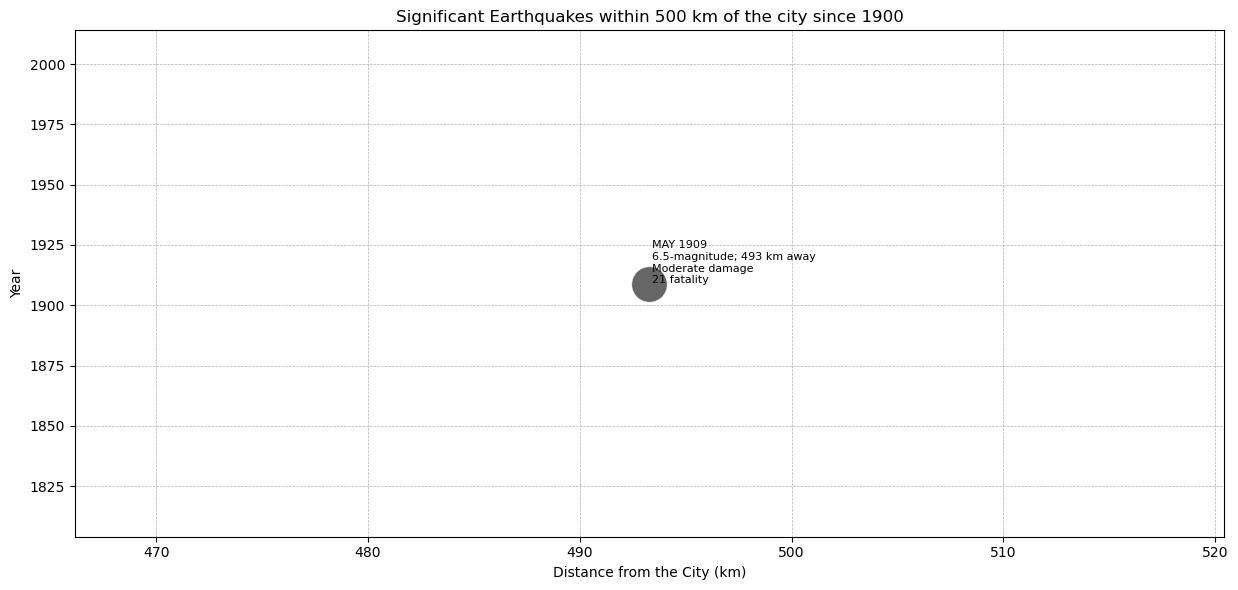

In [90]:
get_earthquake_timeline()

In [94]:

def export_outputs_to_markdown(notebook_path, render_folder, output_path, city):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Initialize the Markdown exporter
    markdown_exporter = MarkdownExporter()
    markdown_exporter.exclude_input = True  
    markdown_output, resources = markdown_exporter.from_notebook_node(notebook_content)
    markdown_output_path = os.path.join(render_folder, output_path)
    with open(markdown_output_path, 'w', encoding='utf-8') as f:
        f.write(markdown_output)

    base_dir = render_folder
    print(f"Base directory for organizing files: {base_dir}")
    plots_folder = os.path.join(base_dir, "plots")
    html_folder = os.path.join(plots_folder, "html")
    png_folder = os.path.join(plots_folder, "png")
    
    print(f"Creating folders:\n- {plots_folder}\n- {html_folder}\n- {png_folder}")

    os.makedirs(html_folder, exist_ok=True)
    os.makedirs(png_folder, exist_ok=True)

    for file in os.listdir(base_dir):
        if file.endswith(".html"):
            shutil.move(os.path.join(base_dir, file), os.path.join(html_folder, file))
            print(f"Moved {file} to {html_folder}")
        elif file.endswith(".png"):
            shutil.move(os.path.join(base_dir, file), os.path.join(png_folder, file))
            print(f"Moved {file} to {png_folder}")

input_notebook_path = "text.ipynb"
output_markdown_path = f"{city}_output_notebook.md"

export_outputs_to_markdown(input_notebook_path, render_folder, output_markdown_path, city)


Base directory for organizing files: mnt/city-directories/03-render-output
Creating folders:
- mnt/city-directories/03-render-output/plots
- mnt/city-directories/03-render-output/plots/html
- mnt/city-directories/03-render-output/plots/png
Moved guiyang-oxford-gdp-plot.png to mnt/city-directories/03-render-output/plots/png
Moved Guiyang_pop_growth.html to mnt/city-directories/03-render-output/plots/html
Moved guìyáng-pop-density-plotly.html to mnt/city-directories/03-render-output/plots/html
Moved guiyang_comb_wsf.png to mnt/city-directories/03-render-output/plots/png
Moved guiyang-oxford-gdp-plot.html to mnt/city-directories/03-render-output/plots/html
Moved guiyang_earthquake_timeline.png to mnt/city-directories/03-render-output/plots/png
Moved guiyang_urban_built_up_area.png to mnt/city-directories/03-render-output/plots/png
Moved guiyang_flood_timeline.html to mnt/city-directories/03-render-output/plots/html
Moved guiyang-oxford-employment-sectors.png to mnt/city-directories/03-ren